# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Загрузка изображения
image_path = 'periodic_noise.jpg'
original_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

if original_image is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path}")

print(f"Размер изображения: {original_image.shape}")
print(f"Диапазон значений: {original_image.min()} - {original_image.max()}")

Размер изображения: (594, 787)
Диапазон значений: 0 - 255


In [2]:
# Вычисление дискретного преобразования Фурье
dft_result = cv.dft(np.float32(original_image), flags=cv.DFT_COMPLEX_OUTPUT)

# Сдвиг нулевой частоты в центр
dft_shifted = np.fft.fftshift(dft_result)

# Вычисление амплитудного спектра
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shifted[:,:,0], dft_shifted[:,:,1]) + 1e-10)  # +1e-10 чтобы избежать log(0)

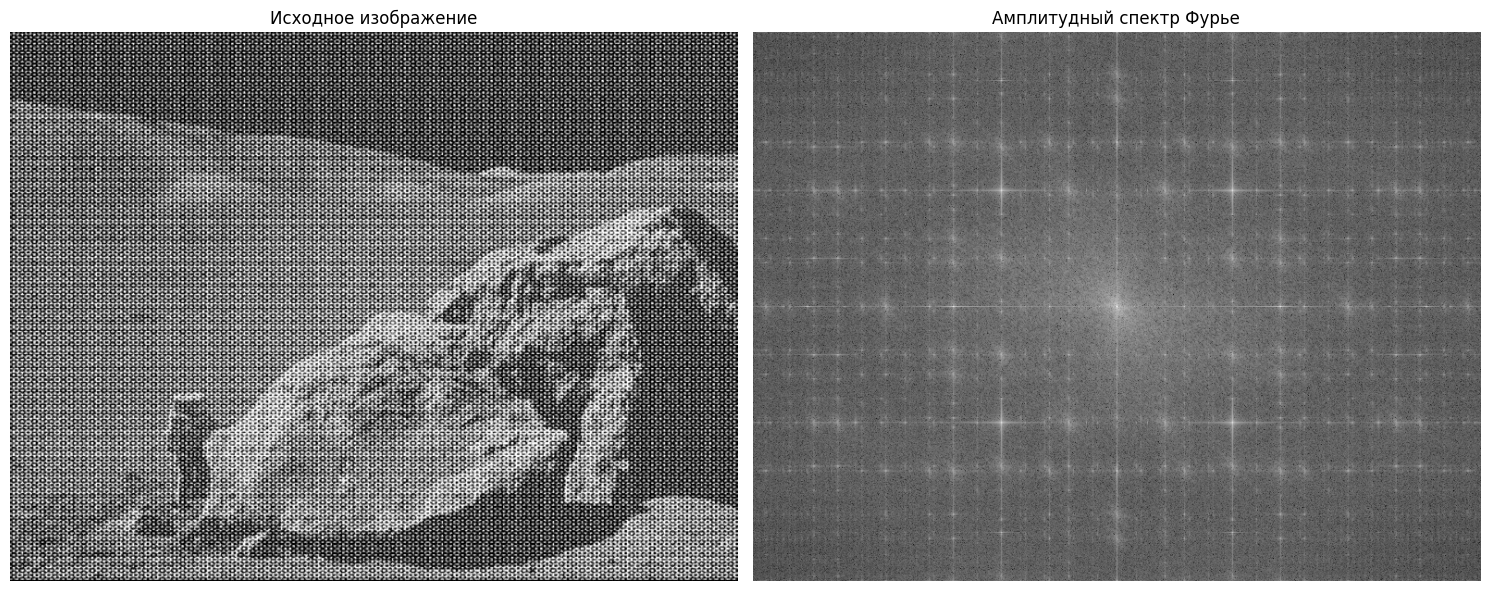

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Исходное изображение
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

# Амплитудный спектр
axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[1].set_title('Амплитудный спектр Фурье')
axes[1].axis('off')

plt.tight_layout()
plt.show()

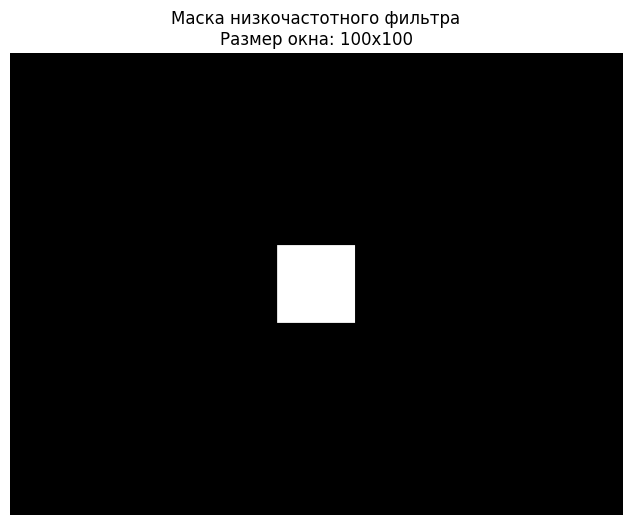

In [4]:
# Инициализация маски фильтра
filter_mask = np.zeros((original_image.shape[0], original_image.shape[1], 2), dtype=np.uint8)

# Определение центра изображения
center_row = original_image.shape[0] // 2
center_col = original_image.shape[1] // 2

# Создание прямоугольного окна (низкочастотный фильтр)
window_size = 50
filter_mask[center_row-window_size:center_row+window_size,
            center_col-window_size:center_col+window_size, :] = 1

# Визуализация маски фильтра
plt.figure(figsize=(8, 6))
plt.imshow(filter_mask[:,:,0], cmap='gray')
plt.title(f'Маска низкочастотного фильтра\nРазмер окна: {window_size*2}x{window_size*2}')
plt.axis('off')
plt.show()

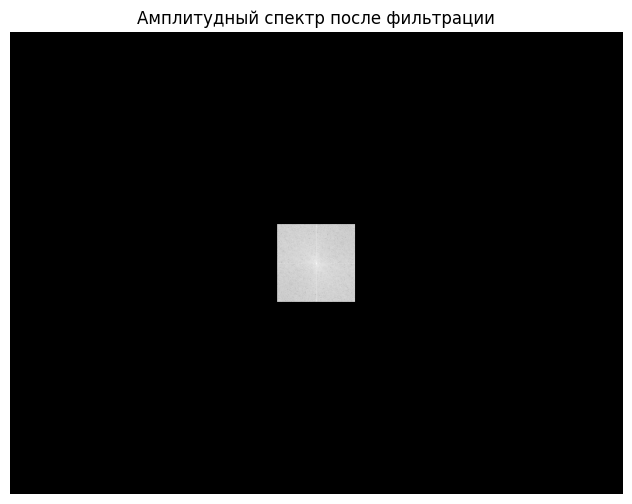

In [5]:
# Умножение спектра на маску фильтра
filtered_dft = dft_shifted * filter_mask

# Вычисление отфильтрованного амплитудного спектра
filtered_spectrum = 20 * np.log(cv.magnitude(filtered_dft[:,:,0], filtered_dft[:,:,1]) + 1e-10)

# Визуализация отфильтрованного спектра
plt.figure(figsize=(8, 6))
plt.imshow(filtered_spectrum, cmap='gray')
plt.title('Амплитудный спектр после фильтрации')
plt.axis('off')
plt.show()

In [6]:
# Обратный сдвиг частот
inverse_shift = np.fft.ifftshift(filtered_dft)

# Обратное преобразование Фурье
inverse_dft = cv.idft(inverse_shift)

# Вычисление величины (восстановление изображения)
restored_image = cv.magnitude(inverse_dft[:,:,0], inverse_dft[:,:,1])

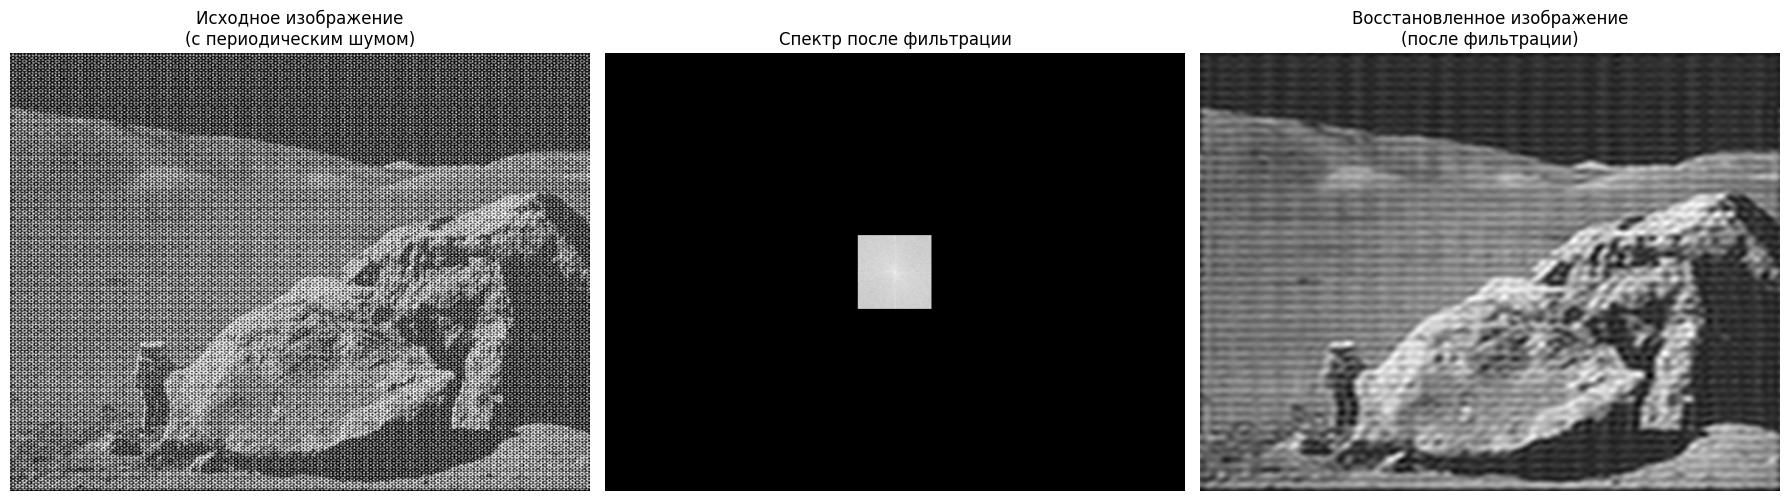

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Исходное изображение
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Исходное изображение\n(с периодическим шумом)')
axes[0].axis('off')

# Отфильтрованный спектр
axes[1].imshow(filtered_spectrum, cmap='gray')
axes[1].set_title('Спектр после фильтрации')
axes[1].axis('off')

# Восстановленное изображение
axes[2].imshow(restored_image, cmap='gray')
axes[2].set_title('Восстановленное изображение\n(после фильтрации)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

АНАЛИЗ РЕЗУЛЬТАТОВ ФИЛЬТРАЦИИ
Размер изображения: (594, 787)
Центр изображения: (297, 393)
Размер фильтра: 100x100

Интенсивность исходного изображения:
  Среднее: 107.65
  Стандартное отклонение: 74.93

Интенсивность восстановленного изображения:
  Среднее: 50324840.00
  Стандартное отклонение: 14238584.00


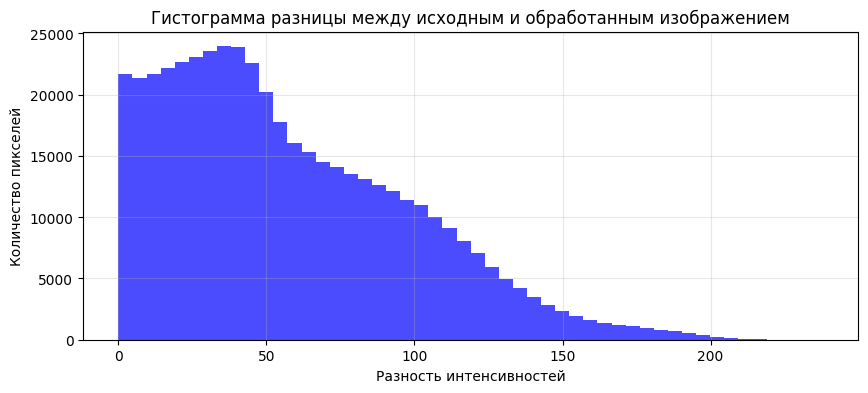

In [8]:
# Нормализация восстановленного изображения
restored_normalized = cv.normalize(restored_image, None, 0, 255, cv.NORM_MINMAX)

print("=" * 60)
print("АНАЛИЗ РЕЗУЛЬТАТОВ ФИЛЬТРАЦИИ")
print("=" * 60)
print(f"Размер изображения: {original_image.shape}")
print(f"Центр изображения: ({center_row}, {center_col})")
print(f"Размер фильтра: {window_size*2}x{window_size*2}")
print(f"\nИнтенсивность исходного изображения:")
print(f"  Среднее: {np.mean(original_image):.2f}")
print(f"  Стандартное отклонение: {np.std(original_image):.2f}")
print(f"\nИнтенсивность восстановленного изображения:")
print(f"  Среднее: {np.mean(restored_image):.2f}")
print(f"  Стандартное отклонение: {np.std(restored_image):.2f}")
print("=" * 60)

# Дополнительная визуализация разницы
if original_image.shape == restored_normalized.shape:
    difference = cv.absdiff(original_image.astype(np.float32),
                           restored_normalized.astype(np.float32))

    plt.figure(figsize=(10, 4))
    plt.hist(difference.flatten(), bins=50, alpha=0.7, color='blue')
    plt.title('Гистограмма разницы между исходным и обработанным изображением')
    plt.xlabel('Разность интенсивностей')
    plt.ylabel('Количество пикселей')
    plt.grid(alpha=0.3)
    plt.show()